In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import torch
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from simpletransformers.classification import ClassificationModel

from typing import List, Tuple, Dict, Union, Any

In [5]:
import helpers, models
from helpers import pipeline
from models import BertweetClassifier, BaselineModel, Ensemble

In [7]:
# parameters
FULL = False
SEED = 42
TEST_SIZE = 0.3

In [ ]:
# run for main model

MODEL_CLASS = BertweetClassifier
MODEL_ARGS = {
    'manual_seed': 69,
    'num_train_epochs': 1,
    'train_batch_size': 16,
    'learning_rate': 2e-5, 
    'dropout': 0.1,
    'weight_decay': 0.01,
    'warmup_ratio': 0.1,
    'optimizer': 'AdamW',
    'overwrite_output_dir': True,
}
OUT_PATH = 'submission.csv'

pipeline(
    full=FULL,
    seed=SEED,
    test_size=TEST_SIZE,
    model_class=MODEL_CLASS,
    model_args=MODEL_ARGS,
    out_path=OUT_PATH
)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/140000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/8750 [00:00<?, ?it/s]

  0%|          | 0/140000 [00:00<?, ?it/s]

  0%|          | 0/17500 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Training accuracy: 93.23%
Testing accuracy: 90.76%


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

In [ ]:
# run for baseline model

BASELINE_MODEL_CLASS = BaselineModel
BASELINE_MODEL_ARGS = {'n': 2, 'p': 0.25}

pipeline(
    full=FULL,
    seed=SEED,
    test_size=TEST_SIZE,
    model_class=BASELINE_MODEL_CLASS,
    model_args=BASELINE_MODEL_ARGS
)

Training accuracy: 95.86%
Testing accuracy: 80.03%


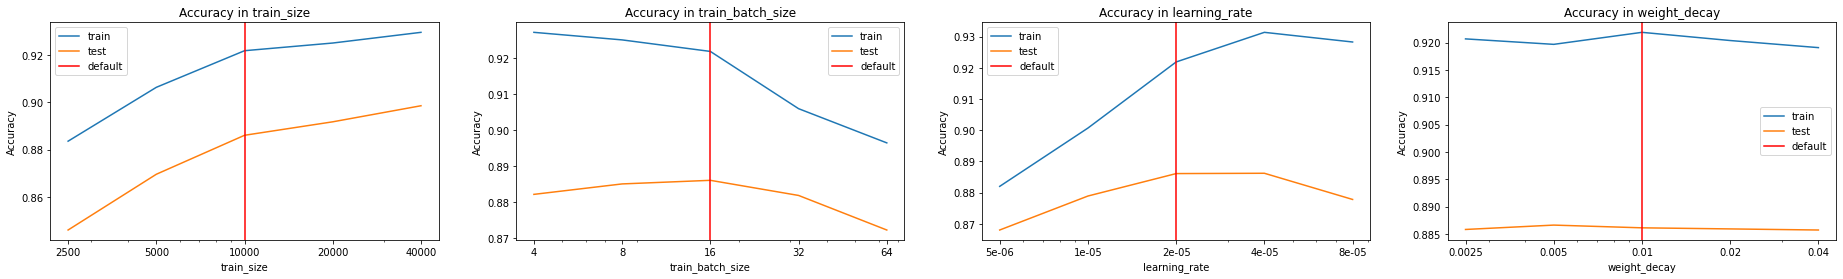

In [141]:
# sensitivity analysis

RUN_SENSITIVITY_ANALYSIS = False

default_config = {
    'manual_seed': 69,
    'num_train_epochs': 1,
    'train_batch_size': 16,
    'learning_rate': 2e-5,
    'dropout': 0.1,
    'weight_decay': 0.01,
    'warmup_ratio': 0.1,
    'optimizer': 'AdamW',
    'overwrite_output_dir': True
}
sensitivity_params = {
    'train_size': [2500, 5000, 10000, 20000, 40000],
    'train_batch_size': [4, 8, 16, 32, 64],
    'learning_rate': [5e-6, 1e-5, 2e-5, 4e-5, 8e-5],
    'weight_decay': [0.0025, 0.005, 0.01, 0.02, 0.04]
}
default_n = 10000

if RUN_SENSITIVITY_ANALYSIS:
    for param_name, param_values in sensitivity_params.items():
        helpers.sensitivity_analysis(BertweetClassifier, default_config, param_name, param_values, default_n)

helpers.plot_sensitivity_analysis_results(sensitivity_params)

In [143]:
# preprocessing

ts = 10000
X_train, y_train, X_test, y_test = helpers.get_data(False, 42, 0.3)
X_train, y_train, X_test, y_test = X_train[:ts], y_train[:ts], X_test[:ts], y_test[:ts]

X_train, X_test = helpers.normalizeTweets(X_train), helpers.normalizeTweets(X_test)

clf = BertweetClassifier(default_config)
clf.fit(X_train, y_train)

print(f'Training accuracy: {helpers.calc_clf_acc(y_train, clf.predict(X_train)) * 100:.2f}%')
print(f'Testing accuracy: {helpers.calc_clf_acc(y_test, clf.predict(X_test)) * 100:.2f}%')

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Training accuracy: 90.50%


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Testing accuracy: 88.24%


In [126]:
# simple ensembling

N_MODELS = 3

ts = 10000
X_train, y_train, X_test, y_test = helpers.get_data(False, 42, 0.3)
X_train, y_train, X_test, y_test = X_train[:ts], y_train[:ts], X_test[:ts], y_test[:ts]

clf = models.Ensemble(
    model_class=BertweetClassifier,
    model_args=default_config,
    n_models=N_MODELS
)
clf.fit(X_train, y_train)

y_train_hat = clf.predict(X_train)
y_test_hat = clf.predict(X_test)
train_acc = helpers.calc_clf_acc(y_train, y_train_hat)
test_acc = helpers.calc_clf_acc(y_test, y_test_hat)
print(f'Training accuracy: {train_acc * 100:.2f}%')
print(f'Testing accuracy: {test_acc * 100:.2f}%')

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/625 [00:00<?, ?it/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/625 [00:00<?, ?it/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Training accuracy: 92.25%
Testing accuracy: 88.78%
